In [5]:
import numpy as np
import pandas as pd
from pprint import pprint
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import numpy as np
from sklearn import linear_model, svm

df = pd.read_csv('../all_data.csv',header=0, index_col=0)
df['sum'] = df.sum(axis=1, numeric_only=True)

for i in df.index:
    if df.loc[i]['sum'] == 0:
        df.drop(i, inplace=True)
df.drop('sum', axis=1, inplace=True)

print("Calculating correlation...")
corr = {}
for k in df.index:
    if k == 'highrisk': continue
  #print("Processing {}".format(k))
    corr[k] = np.absolute(np.corrcoef(df.loc['highrisk',:], df.loc[k,:]))[0,1] 

keys = list(corr.keys())
for k in keys:
    if np.isnan(corr[k]):
        corr.pop(k, None)

values = list(corr.values())
srtd_ix = np.argsort(values)

logistic = linear_model.LogisticRegression(C=1e5)
rbf = svm.SVC(kernel='linear')
lr_total_accuracies = []
svm_total_accuracies = []

n_features = [10, 100, 200, 400, 600, 800, 900, 1200, 1600, 3200, 4800, 6400, 7876]

#pprint(df.loc[ [ keys[fid] for fid in srtd_ix[0:99] ],:])
#print("Exporting to CSV...")
for i in n_features:
    df.loc[ [ keys[fid] for fid in srtd_ix[-i:] ],:].to_csv('../final_data.csv')
    #print(values[srtd_ix[-i]])
    features = np.loadtxt(open("../final_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94) )
    features = features.transpose()
    features = stats.zscore(features)
    y = np.loadtxt(open("../all_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94))
    y = y[0,:]

    lr_accuracies = []
    svm_accuracies = []
    skf = StratifiedKFold(n_splits=10)

    for train_index, test_index in skf.split(features, y):
        train_data, test_data = features[train_index], features[test_index]
        train_labels, test_labels = y[train_index], y[test_index]
        
        log_acc = logistic.fit(train_data, train_labels).score(test_data, test_labels)
        lr_accuracies = np.append(lr_accuracies, log_acc)
        svm_acc = rbf.fit(train_data, train_labels).score(test_data, test_labels)
        svm_accuracies = np.append(svm_accuracies, svm_acc)
        
        log_acc_avg = np.mean(lr_accuracies)*100
        svm_acc_avg = np.mean(svm_accuracies)*100
    #print('Logistic Regression Accuracy: %f' % log_acc_avg)
    #print('SVM Regression Accuracy: %f' % svm_acc_avg)
    lr_total_accuracies = np.append(lr_total_accuracies, log_acc_avg)
    svm_total_accuracies = np.append(svm_total_accuracies, svm_acc_avg)
print(max(lr_total_accuracies))
print(max(svm_total_accuracies))

Calculating correlation...
96.7777777778
93.6666666667


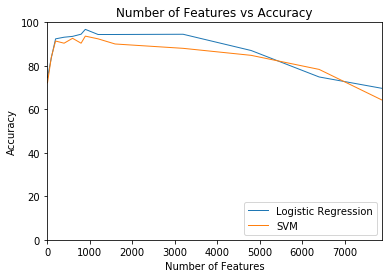

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(n_features, lr_total_accuracies, lw=1, label='Logistic Regression')
plt.plot(n_features, svm_total_accuracies, lw=1, label='SVM')
plt.xlim([0, 7876])
plt.ylim([0, 100])
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Number of Features vs Accuracy')
plt.legend(loc="lower right")
#plt.savefig('feat_acc.eps')
plt.show()
plt.save('')
